# Question 4

In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

Add your answer to this question along with code and comments in a separate notebook. Upload the notebook in the subsection called "Question 4 - Can a predictive model be built for future prediction of the possibility of Complaints of the specific type that you identified in response to Question 1?" in the section "Submit your work and Review your Peer's work" in the module "Submit Your Work and Grade Your Peers".

**STEP 1 - IMPORT REQUIRED LIBRARIES**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

**STEP 2 - LOAD FILES**

In [2]:
# Read 311 dataset
nyc_data_pre = pd.read_csv("nyc_data_pre.csv")

In [3]:
# Read PLUTO dataset for the 5 boroughs
pluto_BX = pd.read_csv("PLUTO_for_WEB/BX_18v1.csv")
pluto_BK = pd.read_csv("PLUTO_for_WEB/BK_18v1.csv")
pluto_MN = pd.read_csv("PLUTO_for_WEB/MN_18v1.csv")
pluto_QN = pd.read_csv("PLUTO_for_WEB/QN_18v1.csv")
pluto_SI = pd.read_csv("PLUTO_for_WEB/SI_18v1.csv")

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/nando/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20,22,23,24,25,26,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/nando/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (20,23,24,26,64) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/nando/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20,22,23,64,65,77) have mixed types.Specify dt

**STEP 3 - DATA PRE-PROCESSING**

**311 DATASET**

In [4]:
# Rename address column for 311 dataset
nyc_data_pre.rename(columns={"Incident Address":"Address"},inplace=True)

In [5]:
# Drop rows for years 2010 and 2020, as they are incomplete
print("Initial 311 dataset shape before removing the 2010/2020 rows:",nyc_data_pre.shape)
nyc_data_pre.drop(nyc_data_pre[(nyc_data_pre["Created Year"] == 2010) | (nyc_data_pre["Created Year"] == 2020)].index, inplace=True)

# Reset index values with the new rows
nyc_data_pre.reset_index(drop=True, inplace=True)
print("New 311 dataset shape after removing the 2010/2020 rows:",nyc_data_pre.shape)

Initial 311 dataset shape before removing the 2010/2020 rows: (5119327, 16)
New 311 dataset shape after removing the 2010/2020 rows: (5081581, 16)


**PLUTO DATASET**

In [6]:
# Merge the PLUTO datasets
df_pluto = pd.concat([pluto_BX, pluto_BK, pluto_MN, pluto_QN, pluto_SI])

In [7]:
# Select only the important columns for PLUTO dataset
df_pluto = df_pluto[['Address','BldgDepth',"FacilFAR",'BuiltFAR','NumFloors','ResidFAR']]

In [8]:
# Remove duplicate values
print("Initial PLUTO dataset shape before removing the duplicate rows:",df_pluto.shape)
df_pluto.drop_duplicates(subset="Address", keep='first', inplace=True)
print("New PLUTO dataset shape after removing the duplicate rows:",df_pluto.shape)

Initial PLUTO dataset shape before removing the duplicate rows: (859212, 6)
New PLUTO dataset shape after removing the duplicate rows: (828644, 6)


**STEP 4 - DATA ANALYSIS**  
**Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1??**

In [9]:
# Get dataframe from the 311 dataset for heating complaints
df_heating = nyc_data_pre.loc[(nyc_data_pre['Complaint Type'] == "HEATING")]
df_heating = df_heating.reset_index(drop=True)

In [10]:
# Create dataframe df_year to group the number of heating complaints by each year
df_year = df_heating.groupby(df_heating["Created Year"]).count()["Unique Key"].to_frame().reset_index()
df_year

,Created Year,Unique Key
0,2011,121179
1,2012,182188
2,2013,192266
3,2014,230280
4,2015,225637
5,2016,227893
6,2017,213477
7,2018,216998
8,2019,211962


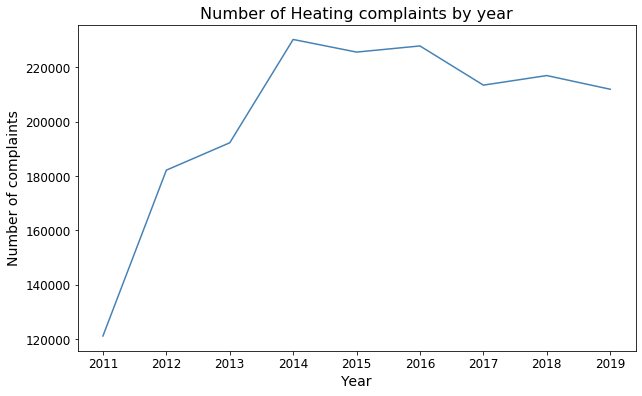

In [11]:
# Visualize the heating complaints by year
df_year.plot(x="Created Year",
             y="Unique Key",
             figsize=(10,6),
             fontsize=12,
             color='steelblue',
             legend=False)

plt.title("Number of Heating complaints by year",fontsize=16)
plt.ylabel("Number of complaints",fontsize=14)
plt.xlabel("Year",fontsize=14)

plt.show()

In [12]:
# Create dataframe df_time to group the number of heating complaints during the time
df_heating['Created Date'] = pd.to_datetime(df_heating['Created Date'])
df_time = pd.Series(1, index = df_heating['Created Date'])
df_time = df_time.resample('M').sum()
df_time.head()

Created Date
2011-01-31       10
2011-02-28        8
2011-03-31    17267
2011-04-30    11783
2011-05-31     4353
Freq: M, dtype: int64

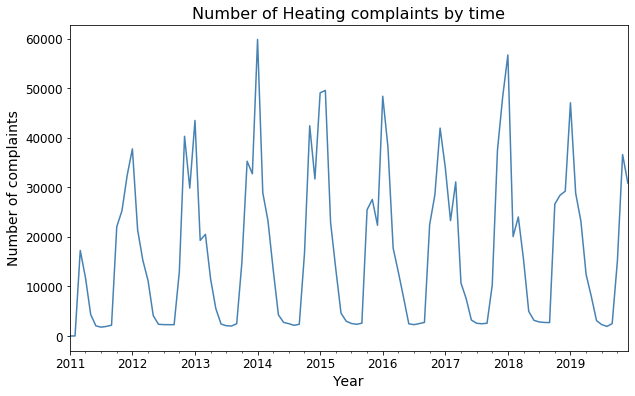

In [13]:
# Visualize the heating complaints during the time
df_time.plot(kind="line",
             figsize=(10,6),
             fontsize=12,
             color='steelblue',
             legend=False)

plt.title("Number of Heating complaints by time",fontsize=16)
plt.ylabel("Number of complaints",fontsize=14)
plt.xlabel("Year",fontsize=14)

plt.show()

**MODELLING VIA 1) SIMPLE LINEAR REGRESSION and 2) SIMPLE POLYNOMIAL REGRESSION**

In [14]:
# Define x & y variables
x = df_year[["Created Year"]]
y = df_year["Unique Key"]

In [15]:
# Define x_predicr array used to predict the y values
x_predict = np.array(range(2011,2024,1))
x_predict = x_predict.reshape(-1, 1)

In [16]:
# Create Simple Linear Regression Model
from sklearn.linear_model import LinearRegression 
linear_reg = LinearRegression()

# Create Simple Polynomial Regression Model of third order
from sklearn.preprocessing import PolynomialFeatures 
  
poly = PolynomialFeatures(degree = 3) 
X_poly = poly.fit_transform(x) 
  
poly.fit(X_poly, y) 

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

In [17]:
# Fit Simple Linear Regression Model
linear_reg.fit(x,y)

# Fit Simple Polynomial Regression Model
lin_poly = LinearRegression() 
lin_poly.fit(X_poly, y) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# Predict y values using Simple Linear Regression Model
Yhat_Linear = linear_reg.predict(x_predict)

# Predict y values using Simple Polynomial Regression Model
Yhat_Polynomial = lin_poly.predict(poly.fit_transform(x_predict))

The expected number of complaints for 2020 using Linear Regression is: [244730.86111111]
The expected number of complaints for 2020 using Polynomial Regression is: [219661.49804688]


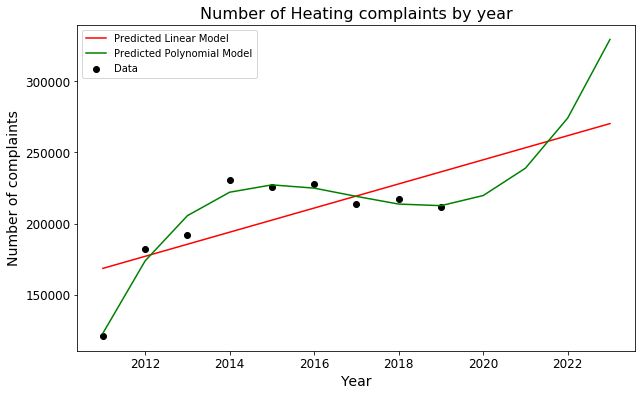

In [19]:
# Visualize the Simple Polynomial Regression Model
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x, y, c="black", alpha=1,label='Data')
ax.plot(x_predict,Yhat_Linear,'r',label='Predicted Linear Model')
ax.plot(x_predict,Yhat_Polynomial,'g',label='Predicted Polynomial Model')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Number of Heating complaints by year",fontsize=16)
plt.ylabel("Number of complaints",fontsize=14)
plt.xlabel("Year",fontsize=14)
plt.legend()

print("The expected number of complaints for 2020 using Linear Regression is:",linear_reg.predict([[2020]]))
print("The expected number of complaints for 2020 using Polynomial Regression is:",lin_poly.predict(poly.fit_transform([[2020]])))

plt.show()

**CREATE MODEL TO PREDICT THE POSSIBILITY OF HEATING COMPLAINTS BASED ON HOUSE CHARACTERISTICS**

**As we have seen in Question 3, the next house characteristics are the most related to heating complaints:**  

1 - BldgDepth  
2 - BuiltFAR   
3 - FacilFAR  
4 - NumFloors  
5 - ResidFAR 

In [ ]:
#
# PRE-ANALYSIS
#

In [20]:
# Create a new dataframe (df_model) which contains the columns "Complaint Type" and "Address" fromt the 311 dataset
df_model = nyc_data_pre[["Complaint Type","Address"]]
df_model.head()

,Complaint Type,Address
0,PAINT/PLASTER,612 EAST 180 STREET
1,HEATING,2196 FREDERICK DOUGLASS BOULEVARD
2,HEATING,310 NORTH BURGHER AVENUE
3,ELECTRIC,605 WEST 142 STREET
4,DOOR/WINDOW,233 WEST 115 STREET


In [22]:
# Convert "Complaint Type" column from df_model to binary: 
# YES for Heating and NO for the rest of complaints
df_model["Complaint Type"] = np.where(df_model["Complaint Type"]=='HEATING','YES',df_model["Complaint Type"])
df_model["Complaint Type"] = np.where(df_model["Complaint Type"]!='YES','NO',df_model["Complaint Type"])
df_model.head()

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nando/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Complaint Type,Address
0,NO,612 EAST 180 STREET
1,YES,2196 FREDERICK DOUGLASS BOULEVARD
2,YES,310 NORTH BURGHER AVENUE
3,NO,605 WEST 142 STREET
4,NO,233 WEST 115 STREET


In [24]:
# Now we merge the df_model and the PLUTO dataset (df_pluto)
df_model = pd.merge(df_model, df_pluto, on='Address', how='inner')
df_model.head()

,Complaint Type,Address,BldgDepth,FacilFAR,BuiltFAR,NumFloors,ResidFAR
0,YES,310 NORTH BURGHER AVENUE,48.0,1.0,0.89,2.5,0.60
1,NO,91-21 195 STREET,110.0,2.0,2.27,4.0,1.25
2,NO,91-21 195 STREET,110.0,2.0,2.27,4.0,1.25
3,YES,91-21 195 STREET,110.0,2.0,2.27,4.0,1.25
4,YES,91-21 195 STREET,110.0,2.0,2.27,4.0,1.25


In [ ]:



# Drop duplicate values
print("Initial shape before removing the rows:",df_model.shape)
df_model.drop_duplicates(keep='first', inplace=True)
df_model.reset_index(drop=True, inplace=True)
print("New shape after removing the rows:",df_model.shape)





In [ ]:
#
# DEFINE MODEL
#

In [28]:
# Define x & y variables
model_x = df_model[["BldgDepth","FacilFAR","BuiltFAR","NumFloors","ResidFAR"]]
model_y = df_model["Complaint Type"]

In [29]:
# Create training and testing dataset: 70% of the data will be used for training and 30% for testing
from sklearn.model_selection import train_test_split
x_trainset, x_testset, y_trainset, y_testset = train_test_split(model_x, model_y, test_size=0.3, random_state=3)

In [40]:
# Define LogisticRegression model
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver="liblinear")

In [41]:
# Fit the LogisticRegression model
LR.fit(x_trainset,y_trainset)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
# Calculate the predicted values using the testdata
model_y_hat = LR.predict(x_testset)

In [43]:
# Calulate the predicted probability using the testdata
model_y_hat_prob = LR.predict_proba(x_testset)

In [ ]:
#
# MODEL EVALUATION
#

In [34]:
from sklearn.metrics import jaccard_similarity_score
print("Logistic Regression's Jaccard score: ",jaccard_similarity_score(y_testset, model_y_hat))

/Users/nando/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Logistic Regression's Jaccard score:  0.6453163486558645


In [44]:
from sklearn.metrics import classification_report
print("CLASSIFICATION REPORT:")
print(classification_report(y_testset, model_y_hat))

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          NO       0.65      0.99      0.78    763503
         YES       0.38      0.01      0.01    416698

    accuracy                           0.65   1180201
   macro avg       0.51      0.50      0.40   1180201
weighted avg       0.55      0.65      0.51   1180201



In [36]:
from sklearn.metrics import log_loss
print("Logistic Regression's log loss: ",log_loss(y_testset, model_y_hat_prob))

Logistic Regression's log loss:  0.6468285670982931


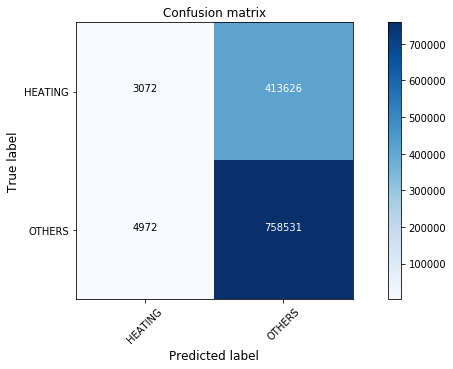

In [45]:
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12)
    plt.xlabel('Predicted label',fontsize=12)
    
    plt.show()

plot_confusion_matrix(confusion_matrix(y_testset, model_y_hat,labels=["YES","NO"]),classes=['HEATING','OTHERS'])

**STEP 5 - CONCLUSIONS**

Initially we have used a **Simple Linear Regression Model** and **Simple Polynomial Regression Model** to predict the number of heating complaints for the year 2020 based on a single variable (date).  The two models created have predicted 244,730 and 219,661 heating complaints respectively for 2020.

Finally we have create a predictive model to estimate the probability of a complaint to be heating or not. To do that we have used a **Logistic Regression Model**, using as independent variable the house characteristics observed in Question 3 (Building depth, Built far, Facil far, Number of floors, Resid far).  

After evaulating the model created, we can conclude that our model can predict the probability of a complaint to be heating with an accuracy of 51%.

In [ ]:
df_time2 = df_time.to_frame().reset_index()

df_time2.columns = ['Date','Complaints']

In [ ]:
import datetime as dt

In [ ]:
df_time2["Date"] = pd.to_datetime(df_time2["Date"])
df_time2["Date"] = df_time2["Date"].map(dt.datetime.toordinal)